# EDA

In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
path = '../../data/'

In [7]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

train = pd.read_csv(path + 'train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
test = pd.read_csv(path + 'test_data.csv', dtype=dtype, parse_dates=['Timestamp'])
submission = pd.read_csv(path + 'sample_submission.csv')

> 시간을 초 단위로 변경

In [8]:
# timetuple, mktime 활용
print("timetuple : ",train['Timestamp'].iloc[0].timetuple())
print("mktime : ",time.mktime(train['Timestamp'].iloc[0].timetuple()))

timetuple :  time.struct_time(tm_year=2020, tm_mon=3, tm_mday=24, tm_hour=0, tm_min=17, tm_sec=11, tm_wday=1, tm_yday=84, tm_isdst=-1)
mktime :  1585009031.0


In [9]:
train['Timestamp'] = train['Timestamp'].apply(lambda x: int(time.mktime(x.timetuple())))
test['Timestamp'] = test['Timestamp'].apply(lambda x: int(time.mktime(x.timetuple())))


> 시간차 column 추가

In [10]:
train['Timediff'] = train.groupby(["userID","testId"])['Timestamp'].diff().fillna(0).astype(int)
test['Timediff'] = test.groupby(["userID","testId"])['Timestamp'].diff().fillna(0).astype(int)

> 시험지별 풀기 시작한 지 얼마나 지났는지 column 추가

In [11]:
train['Timepassed'] = train.groupby(['userID','testId'])['Timediff'].cumsum()
test['Timepassed'] = test.groupby(['userID','testId'])['Timediff'].cumsum()

> Timestamp drop

In [12]:
train = train.drop(columns = 'Timestamp')
test = test.drop(columns = 'Timestamp')

In [13]:
def percentile(s):
    return np.sum(s) / len(s)

## train, test Head

In [14]:
train.head()

,userID,assessmentItemID,testId,answerCode,KnowledgeTag,Timediff,Timepassed
0,0,A060001001,A060000001,1,7224,0,0
1,0,A060001002,A060000001,1,7225,3,3
2,0,A060001003,A060000001,1,7225,8,11
3,0,A060001004,A060000001,1,7225,7,18
4,0,A060001005,A060000001,1,7225,7,25


In [15]:
test.head()

,userID,assessmentItemID,testId,answerCode,KnowledgeTag,Timediff,Timepassed
0,3,A050023001,A050000023,1,2626,0,0
1,3,A050023002,A050000023,1,2626,26,26
2,3,A050023003,A050000023,0,2625,94,120
3,3,A050023004,A050000023,0,2625,5,125
4,3,A050023006,A050000023,0,2623,7,132


## feature 개수

> train 과 test의 시험지와 문제와 tag는 같다, user는 겹치지 않음

In [42]:
idx = [0,1,2,4]
print("num of rows : ",train.shape[0])
for col in train.columns[idx]:
    print(f"{col}'s nunique : ",train[f"{col}"].nunique())

num of rows :  2266586
userID's nunique :  6698
assessmentItemID's nunique :  9454
testId's nunique :  1537
KnowledgeTag's nunique :  912


In [17]:
print("num of rows : ",test.shape[0])
for col in test.columns[idx]:
    print(f"{col}'s nunique : ",test[f"{col}"].nunique())

num of rows :  260114
userID's nunique :  744
assessmentItemID's nunique :  9454
testId's nunique :  1537
KnowledgeTag's nunique :  912


In [18]:
for col in train.columns[idx]:
    print(f"{col}'s compare train, test  : ",len(set(train[f"{col}"].unique()) - set(test[f"{col}"].unique())))

userID's compare train, test  :  6698
assessmentItemID's compare train, test  :  0
testId's compare train, test  :  0
KnowledgeTag's compare train, test  :  0


In [19]:
print("train data null : ",train.isnull().sum().sum())
print("test data null : ",test.isnull().sum().sum())

train data null :  0
test data null :  0


## 정답 오답 개수


> train : 정답이 약 2배가량 많음

In [20]:
answer_count = train['answerCode'].value_counts()
print("answer count : ",answer_count[1])
print("answer rate : ",answer_count[1]/answer_count.sum())
print("wrong answer count : ",answer_count[0])
print("wrong answer rate : ", answer_count[0]/answer_count.sum())

answer count :  1483205
answer rate :  0.654378435232548
wrong answer count :  783381
wrong answer rate :  0.34562156476745204


> test : train과 비슷함

In [21]:
answer_count = test['answerCode'].value_counts()
print("answer count : ",answer_count[1])
print("answer rate : ",answer_count[1]/answer_count.iloc[0:2].sum())
print("wrong answer count : ",answer_count[0])
print("wrong answer rate : ", answer_count[0]/answer_count.iloc[0:2].sum())

answer count :  170383
answer rate :  0.6569109765971393
wrong answer count :  88987
wrong answer rate :  0.3430890234028608


## feature 별 분포

### UserID

In [22]:
user_group_train = train.groupby('userID')
user_group_test = test.groupby('userID')

In [23]:
def draw_group(group,col : str) -> None:
    fig,ax = plt.subplots()
    groupby = (set(train.columns) - set(group.count().columns)).pop()

    group[col].count().hist(bins = 20,ax =ax)
    
    ax.set_title(groupby + " | count")
    ax.set_xlabel("by " + groupby)
    ax.set_ylabel("Count")
    ax.set_label("median")

    ax.axvline(group[col].count().median(),label = "Median",color = 'tomato')
    ax.axvline(group[col].count().mean(),label = "Mean",color = 'orange')
    ax.legend(
        title = "Describe"
    )
    plt.show()

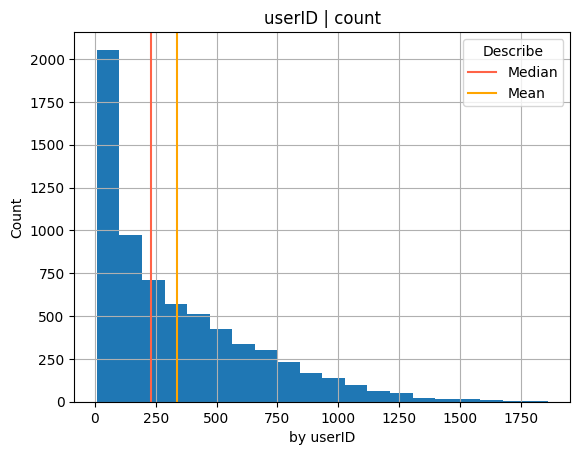

In [24]:
draw_group(user_group_train,"assessmentItemID")

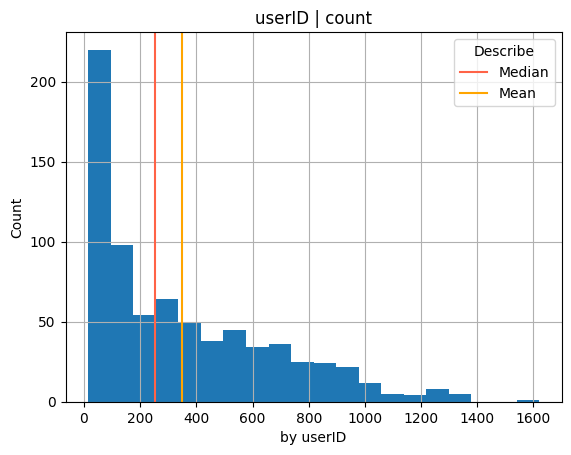

In [25]:
draw_group(user_group_test,"assessmentItemID")

### assessmentItemID

> 한 사람이 문제를 여러번 푼 경우

In [43]:
user_assessment_group = test.groupby('userID').agg({"assessmentItemID":(lambda x:x)})
user_assessment_group = user_assessment_group.reset_index()


In [57]:
user_assessment_group

,userID,assessmentItemID
0,0,"[A060001001, A060001002, A060001003, A06000100..."
1,1,"[A040013001, A040013002, A040013003, A04001300..."
2,2,"[A030050001, A030050002, A030050003, A03005000..."
3,5,"[A080001001, A080001002, A080001003, A08000100..."
4,6,"[A030016001, A030016002, A030016003, A03001600..."
...,...,...
6693,7436,"[A050095001, A050095002, A050095003, A05009500..."
6694,7437,"[A040072001, A040072002, A040072003, A04007200..."
6695,7438,"[A080002001, A080002002, A080002003, A08000200..."
6696,7440,"[A050096001, A050096002, A050096005, A05009600..."


In [58]:
user_assessment_group = train.groupby('userID').agg({"assessmentItemID":(lambda x:x)})

In [59]:
user_assessment_group = user_assessment_group.reset_index()

In [60]:
duplicated_dic = {}
for i in range(6698):
    duplicated_dic[user_assessment_group.loc[i,'userID']] = pd.Series(user_assessment_group.loc[i,"assessmentItemID"]).duplicated().sum()

In [61]:
duplicated_dic
data = pd.DataFrame({'userID' : duplicated_dic.keys(),'duplicated' : duplicated_dic.values()})

In [62]:
data[data['duplicated']>0]

,userID,duplicated
1,1,54
4,6,34
13,16,125
28,34,224
34,40,62
...,...,...
6024,6690,5
6031,6698,14
6181,6858,10
6291,6977,5


In [63]:
data['duplicated'].sum()

45953

> 한 문제당 푼 횟수 분포

In [31]:
assessment_group_train = train.groupby('assessmentItemID')
assessment_group_test = test.groupby('assessmentItemID')

In [32]:
print("문제당 최대 유저 수 : ",assessment_group_train["userID"].count().max())
print("문제당 최소 유저 수 : ",assessment_group_train["userID"].count().min())


문제당 최대 유저 수 :  454
문제당 최소 유저 수 :  43


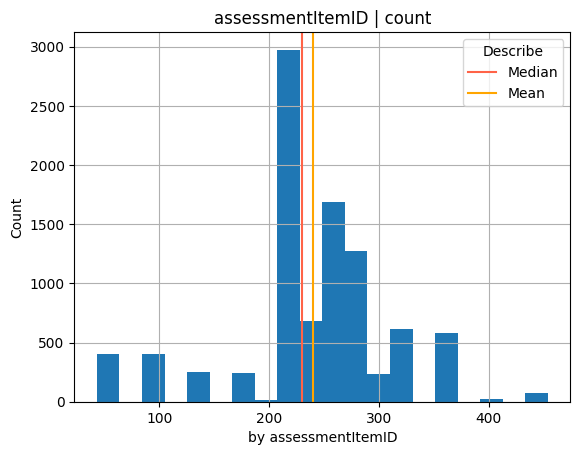

In [33]:
draw_group(assessment_group_train,"userID")

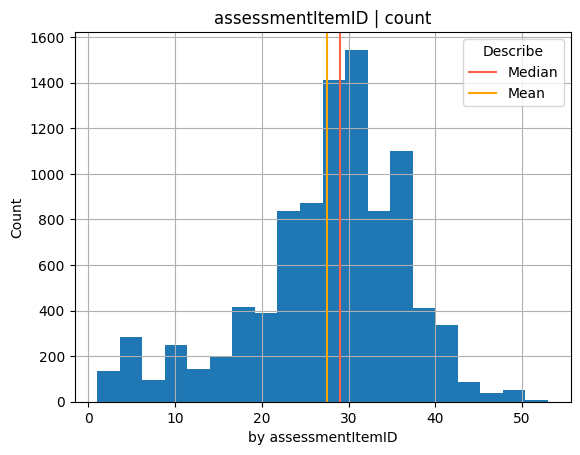

In [34]:
draw_group(assessment_group_test,"userID")

## TestID

## Timepassed

In [35]:
train.groupby("Timepassed").agg({"answerCode" : percentile, "userID":'count'})

,answerCode,userID
Timepassed,,
0,0.750662,365620
1,0.228117,7483
2,0.224625,17803
3,0.226958,17501
4,0.266208,18185
...,...,...
28696496,1.000000,1
28696535,1.000000,1
28696570,0.000000,1


In [36]:
train.groupby("Timepassed").agg({"answerCode" : percentile, "userID":'count'}).reset_index()

,Timepassed,answerCode,userID
0,0,0.750662,365620
1,1,0.228117,7483
2,2,0.224625,17803
3,3,0.226958,17501
4,4,0.266208,18185
...,...,...,...
63449,28696496,1.000000,1
63450,28696535,1.000000,1
63451,28696570,0.000000,1
63452,28696674,1.000000,1


In [37]:
train[train["Timepassed"]>10000]

,userID,assessmentItemID,testId,answerCode,KnowledgeTag,Timediff,Timepassed
801,1,A040049004,A040000049,0,2071,7905,12390
802,1,A040049005,A040000049,0,2071,3,12393
1122,1,A040050005,A040000050,1,2071,372,10258
1397,1,A040155001,A040000155,1,2111,4877683,4877953
1398,1,A040155002,A040000155,1,2111,39,4877992
...,...,...,...,...,...,...,...
2264829,7328,A050086007,A050000086,0,10332,12,10886
2264863,7329,A040198001,A040000198,1,2133,24535065,24535088
2264864,7329,A040198002,A040000198,1,2133,4,24535092
2264865,7329,A040198003,A040000198,1,2133,9,24535101


In [38]:
train[train["testId"] == 'A040000198'].iloc[-20:]

,userID,assessmentItemID,testId,answerCode,KnowledgeTag,Timediff,Timepassed
2247991,6695,A040198001,A040000198,1,2133,0,0
2247992,6695,A040198002,A040000198,1,2133,4,4
2247993,6695,A040198003,A040000198,0,2133,29,33
2247994,6695,A040198004,A040000198,1,2133,12,45
2256517,6939,A040198001,A040000198,1,2133,0,0
2256518,6939,A040198002,A040000198,1,2133,5,5
2256519,6939,A040198003,A040000198,1,2133,13,18
2256520,6939,A040198004,A040000198,1,2133,12,30
2259755,7072,A040198001,A040000198,1,2133,0,0
2259756,7072,A040198002,A040000198,1,2133,7,7
